This notebook demonstrates the straightforward computation of the "temporally-averaged reference image" (known in the RABASAR paper as the super image; this terminology sounds a little too Nietzschean for our taste).

### Notes

+ We do not compute a reference image using any change detection. This is called a "binary weighted" scheme in the [RABASAR paper](https://hal.archives-ouvertes.fr/hal-01791355/). This requires removing relative changes to a fixed image in the time series. Our application of change detection using the perscribed method was effective, but still produced artifacts when the averaging excluded only a few images within the time series. We also found that without change detection, the results were still reasonable.
+ We also have to do some spatial denoising as in the previous notebook on the temporally-averaged reference. We will recompute the ENL for the temporally-averaged image.

In [1]:
import rasterio
import numpy
import scipy
from rabasar import (admm_spatial_denoise, 
                     interpolate_nn, 
                     get_enl_img, 
                     get_enl_mode, 
                     get_enl_mask,
                     scale_img)
from itertools import starmap
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# Read Config File

In [2]:
config_dict = json.load(open('config.json', 'r'))
config_dict

{'sensor': 'alos1',
 'site': 'waxlake',
 'regularizer': 'bm3d',
 'spatial_weight': 0.05,
 'temporal_average_spatial_weight': 0.005,
 'ratio_weight': 0.05}

In [3]:
SENSOR = config_dict['sensor']
SITE = config_dict['site']
REGULARIZER = config_dict['regularizer']

# Data Paths

In [4]:
data_dir_path_name = f'{SENSOR}_{SITE}/data_reprojected'
DATA_DIR = Path(data_dir_path_name)
DATA_DIR.exists()

True

In [5]:
TEMPORALLY_AVERAGED_IMAGE_DIR = Path(f'out/{SENSOR}_{SITE}_{REGULARIZER}/temporally_averaged_image')
TEMPORALLY_AVERAGED_IMAGE_DIR.mkdir(exist_ok=True, parents=True)

In [6]:
TEMPORALLY_AVERAGED_IMAGE_DIR_TV = Path(f'out/{SENSOR}_{SITE}_{REGULARIZER}/temporally_averaged_image_{REGULARIZER}')
TEMPORALLY_AVERAGED_IMAGE_DIR_TV.mkdir(exist_ok=True, parents=True)

In [7]:
hh_paths = sorted(list(DATA_DIR.glob('*/*hh*.tif')))
hv_paths = sorted(list(DATA_DIR.glob('*/*hv*.tif')))
if SENSOR == 'uavsar':
    vv_paths = sorted(list(DATA_DIR.glob('*/*vv*.tif')))

hv_paths

[PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20071015.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20080601.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20080717.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20080901.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20081017.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20090720.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20091020.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20100607.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20101208.tif')]

In [8]:
with rasterio.open(hv_paths[0]) as ds:
    profile = ds.profile

In [9]:
def read_arr(path):
    with rasterio.open(path) as ds:
        arr = ds.read(1)
    arr = np.clip(arr, 1e-4, .7)
    return arr
hv_ts = list(map(read_arr, hv_paths))
hh_ts = list(map(read_arr, hh_paths))
if SENSOR == 'uavsar':
    vv_ts = list(map(read_arr, vv_paths))

# Subset and Display

In [10]:
if SITE == 'waxlake' and SENSOR == 'uavsar' and REGULARIZER == 'tv':
    sy = np.s_[-2000:-1000]
    sx = np.s_[-3000:-2000]
elif SITE == 'waxlake' and SENSOR == 'alos1' and REGULARIZER == 'tv':
    sy = np.s_[3_900:4_900]
    sx = np.s_[2_800:3_800]
elif REGULARIZER == 'bm3d':
    sy = sx = np.s_[:]
else:
    raise NotImplementedError

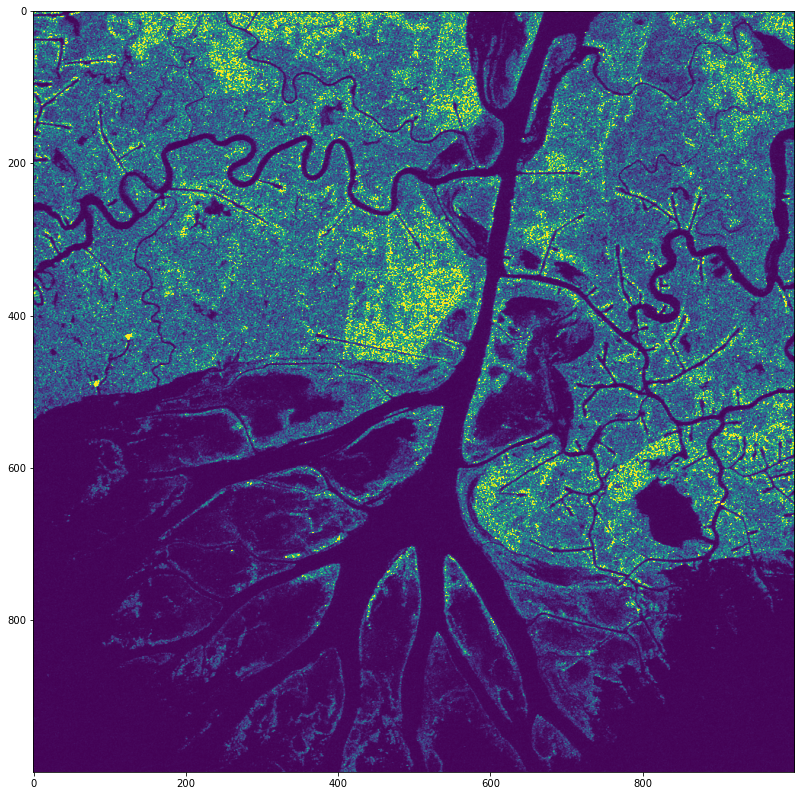

In [11]:
plt.figure(figsize=(14, 14))
plt.imshow(hv_ts[0][sy, sx], vmin=0, vmax=.1)

# The Temporal Average

Stack the images and take their average.

In [12]:
def temporal_average(pol):
    if pol == 'hh':
        ts = hh_ts
    elif pol == 'vv':
        ts = vv_ts
    else:
        ts = hv_ts
    n = len(ts)
    stack = np.stack(ts, axis=2)
    temporally_averaged_image = np.nanmean(stack, axis=2)
    return temporally_averaged_image

In [13]:
ta_image = temporal_average('hv')

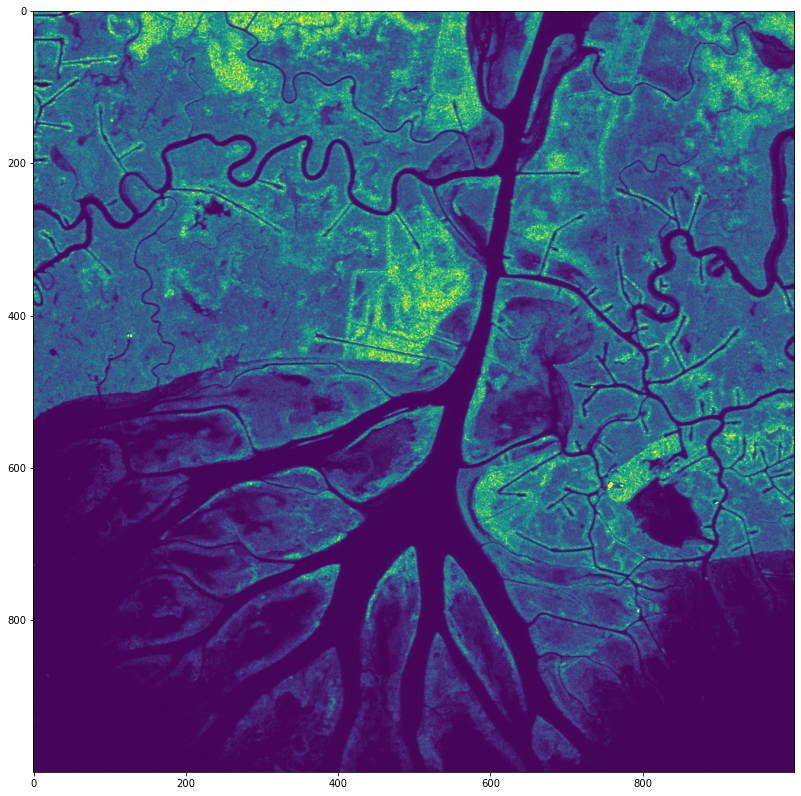

In [14]:
plt.figure(figsize=(14, 14))
plt.imshow(ta_image[sy, sx], vmin=0, vmax=.1)

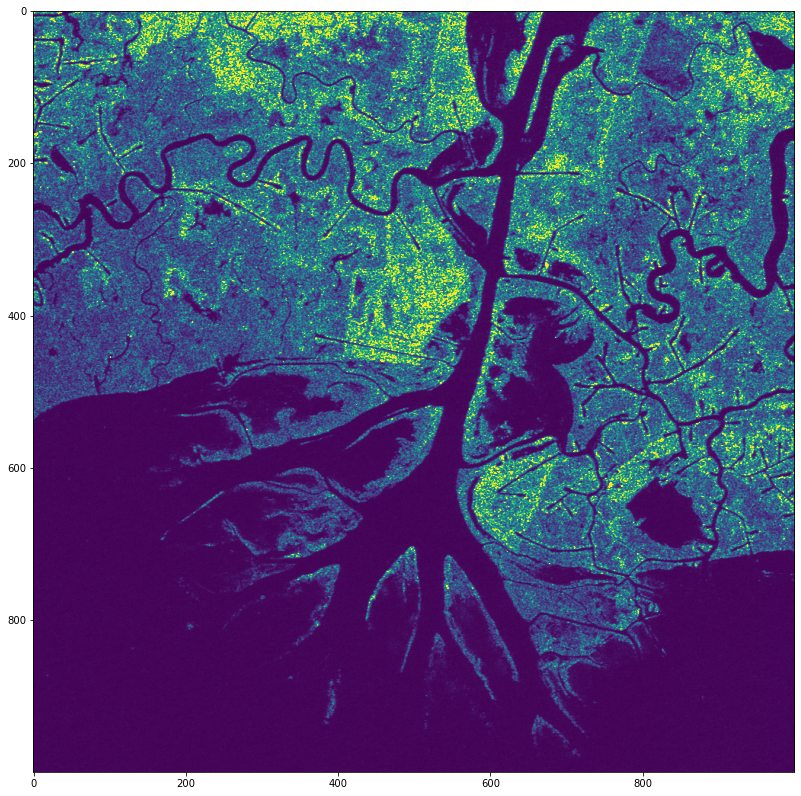

In [15]:
plt.figure(figsize=(14, 14))
plt.imshow(hv_ts[1][sy, sx], vmin=0, vmax=.1)

## Compute the temporal averages for each polarization

In [16]:
ta_hh = temporal_average('hh')
ta_hv = temporal_average('hv')
if SENSOR == 'uavsar':
    ta_vv = temporal_average('vv')

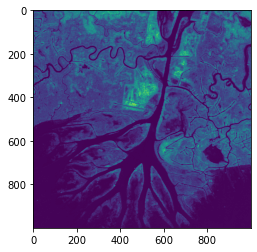

In [17]:
plt.imshow(ta_hh[sy, sx])

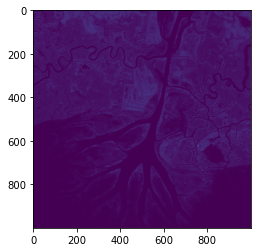

In [18]:
plt.imshow(ta_hv[sy, sx])

In [19]:
if SENSOR == 'uavsar':
    imgs, pols = [ta_hh, ta_hv, ta_vv], ['hh', 'hv', 'vv']
else:
    imgs, pols = [ta_hh, ta_hv], ['hh', 'hv']
for si, pol in zip(tqdm(imgs), pols):
    dest_path = TEMPORALLY_AVERAGED_IMAGE_DIR/f'{SITE}_{SENSOR}_temporally_averaged_{pol}.tif'
    with rasterio.open(dest_path, 'w', **profile) as ds:
        ds.write(si, 1)

100%|██████████| 2/2 [00:00<00:00, 33.30it/s]


# Despeckling the Temporally Averaged Reference

In [20]:
X = ta_hh[sy, sx]
enl_mask = get_enl_mask(X, db_min=-13)
enl_img = get_enl_img(X, 31, enl_max=1_000, mask=enl_mask)
L = round(get_enl_mode(enl_img))
L

20

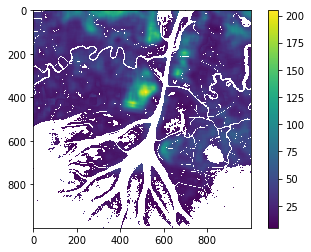

In [21]:
plt.imshow(enl_img, interpolation='none')
plt.colorbar()

Again, can explore the weights on the subset here. For `tv`, we recommend using the same weights as for the purely spatial denoising. The computed ENL $L$ will change because the temporally averaged image will appear smoother and this will make sure less smoothing is done. For `bm3d`, we used an order of magnitude smaller reguarlization parameter.

In [22]:
if REGULARIZER == 'tv':
    regularizer_dict = {
                         'weight': 1
                        }
    
elif REGULARIZER == 'bm3d':
    regularizer_dict = {
                         'weight': .005
                        }
else:
    pass

In [23]:
X = (ta_hh[sy, sx])
X_filled = interpolate_nn(X)
X_den, res_list = admm_spatial_denoise(X_filled,
                                       L,
                                       REGULARIZER,
                                       regularizer_dict, 
                                       max_admm_iterations=10,
                                       newton_iterations=3
                                       )
X_den[np.isnan(X)] = np.nan

admm_iterations: 100%|██████████| 10/10 [04:08<00:00, 24.81s/it]


In [24]:
profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 1000, 'height': 1000, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(12.5, 0.0, 645122.0,
       0.0, -12.5, 3275110.75), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'}

In [25]:
X_den.shape

(1000, 1000)

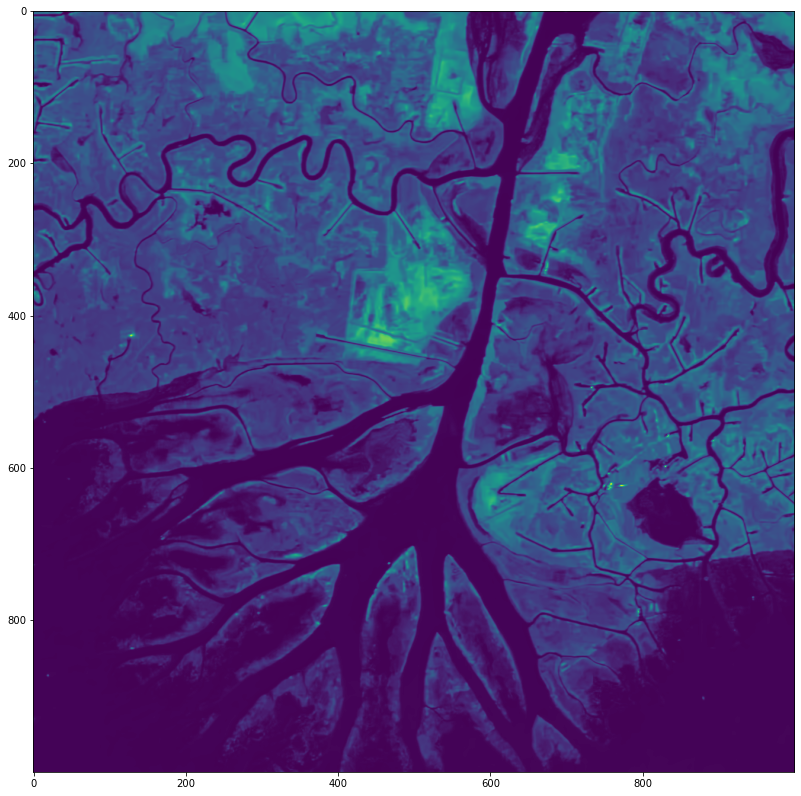

In [26]:
plt.figure(figsize=(14, 14))
plt.imshow(X_den)

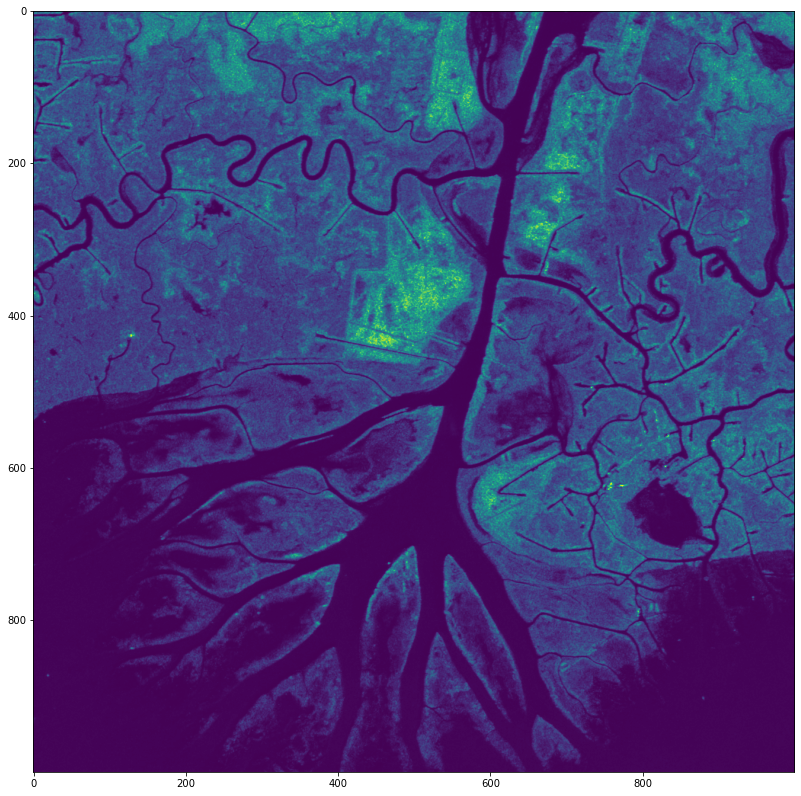

In [27]:
plt.figure(figsize=(14, 14))
plt.imshow(X)

# Despeckle all Temporally Average References

We use the weight from above.

In [28]:
mask = np.isnan(ta_hh)

In [29]:
def denoise_and_write_one_superimage(img, pol, weight):

    regularizer_dict = {
                         'weight': weight
                        }
    
    img_den, res_list = admm_spatial_denoise(img,
                                              L,
                                              REGULARIZER,
                                              regularizer_dict, 
                                              max_admm_iterations=10,
                                              newton_iterations=3
                                              )
    img_den[mask] = np.nan
    
    dest_dir = Path(f'{str(TEMPORALLY_AVERAGED_IMAGE_DIR_TV)}')/f'weight_{weight:1.3f}'
    dest_dir.mkdir(exist_ok=True, parents=True)
    
    dest_path = dest_dir/f'{SITE}_{SENSOR}_temporally_average_{pol}_{REGULARIZER}_{weight:1.3f}.tif'
    with rasterio.open(dest_path, 'w', **profile) as ds:
        ds.write(img_den.astype(np.float32), 1)
    return dest_path

In [30]:
ta_hh_nn = interpolate_nn(ta_hh)
ta_hv_nn = interpolate_nn(ta_hv)
if SENSOR == 'uavsar':
    ta_vv_nn = interpolate_nn(ta_vv)

We are using the `spatial_weight` from our `config.json` as we recommended earlier.

In [31]:
weight = config_dict['temporal_average_spatial_weight']
weight

0.005

In [35]:
if SENSOR == 'uavsar':
    list(starmap(denoise_and_write_one_superimage,zip(tqdm([ta_hh_nn, ta_hv_nn, ta_vv_nn]), 
                                                      # Polarization
                                                      ['hh', 'hv', 'vv'], 
                                                      # Weight
                                                      [weight] * 3
                                                      )))
else:
    list(starmap(denoise_and_write_one_superimage,zip(tqdm([ta_hh_nn, ta_hv_nn]), 
                                                      # Polarization
                                                      ['hh', 'hv'], 
                                                      # Weight
                                                      [weight] * 2
                                                      )))


  0%|          | 0/2 [00:00<?, ?it/s]

admm_iterations:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [01:03<?, ?it/s]0 [00:24<03:40, 24.55s/it]


admm_iterations:  20%|██        | 2/10 [00:49<03:16, 24.59s/it]

admm_iterations:  30%|███       | 3/10 [01:13<02:52, 24.64s/it]

admm_iterations:  40%|████      | 4/10 [01:38<02:28, 24.67s/it]

admm_iterations:  50%|█████     | 5/10 [02:03<02:03, 24.70s/it]

admm_iterations:  60%|██████    | 6/10 [02:28<01:39, 24.78s/it]

admm_iterations:  70%|███████   | 7/10 [02:53<01:14, 24.94s/it]

admm_iterations:  80%|████████  | 8/10 [03:18<00:49, 24.95s/it]

admm_iterations:  90%|█████████ | 9/10 [03:44<00:25, 25.06s/it]

admm_iterations: 100%|██████████| 10/10 [04:09<00:00, 24.96s/it]

admm_iterations: 100%|██████████| 10/10 [04:07<00:00, 24.78s/it]

100%|██████████| 2/2 [09:00<00:00, 270.12s/it]
